<a href="https://colab.research.google.com/github/fikrifaizz/indo-sentiment-engine/blob/main/notebooks/etl_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
df = pd.read_csv("../data/raw/20191002-reviews.csv")

/var/folders/1d/rtg1b32x7sg4fj4dmx9191l40000gn/T/ipykernel_3803/1810214404.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


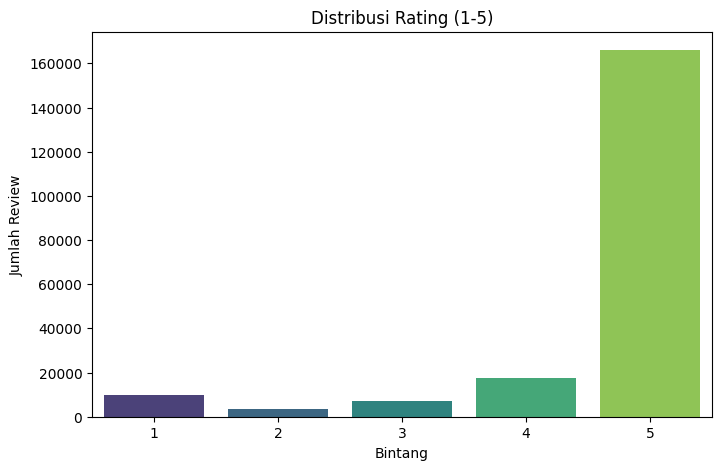

In [5]:
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Distribusi Rating (1-5)')
plt.xlabel('Bintang')
plt.ylabel('Jumlah Review')
plt.show()

In [6]:
rating_counts = df['rating'].value_counts(normalize=True) * 100
print("\nPersentase Rating:")
print(rating_counts)


Persentase Rating:
rating
5    81.465452
4     8.620275
1     4.783917
3     3.470781
2     1.659576
Name: proportion, dtype: float64


In [7]:
duplicate_count = df.duplicated(subset=['reviewContent']).sum()
print(f"Jumlah Review Duplikat (Isi sama persis): {duplicate_count} ({duplicate_count/len(df)*100:.2f}%)")
print("\nTop 5 Review Paling Sering Muncul (Indikasi Spam/Bot):")
print(df['reviewContent'].value_counts().head(5))

Jumlah Review Duplikat (Isi sama persis): 165715 (81.32%)

Top 5 Review Paling Sering Muncul (Indikasi Spam/Bot):
reviewContent
bagus     648
mantap    615
good      462
ok        376
Bagus     257
Name: count, dtype: int64


In [8]:
df['num_words'] = df['reviewContent'].astype(str).apply(lambda x: len(x.split()))
short_reviews = df[df['num_words'] < 3]
print(f"\nReview Terlalu Pendek (< 3 kata): {len(short_reviews)} ({len(short_reviews)/len(df)*100:.2f}%)")
print("Contoh:", short_reviews['reviewContent'].unique()[:10])


Review Terlalu Pendek (< 3 kata): 111217 (54.58%)
Contoh: ['bagus sesuai' nan 'bima' 'Kualitas ok' 'Pengn tivinya' 'Oke' '👍👍👍'
 'siippp...thank lazada' 'josss tenan' 'Sip mantap']


In [9]:
def check_patterns(text):
    flags = {
        'has_html': bool(re.search(r'<.*?>', text)),
        'has_url': bool(re.search(r'http\S+|www\.\S+', text)),
        'has_emoji': bool(re.search(r'[^\w\s,.]', text)), # Kasar: Non-alphanumeric (bisa emoji/simbol)
        'has_repeat_char': bool(re.search(r'(.)\1{2,}', text)), # Contoh: "baaaagus"
        'is_capslock': text.isupper() if len(text) > 4 else False # Teriak
    }
    return pd.Series(flags)

print("\nSedang memindai pola regex...")
patterns_df = df['reviewContent'].astype(str).apply(check_patterns)
audit_summary = patterns_df.sum()

print("\nRINGKASAN NOISE:")
print(audit_summary)


Sedang memindai pola regex...

RINGKASAN NOISE:
has_html               4
has_url               29
has_emoji          22283
has_repeat_char    23765
is_capslock          541
dtype: int64


In [10]:
english_keywords = ['good', 'bad', 'delivery', 'item', 'product', 'fast', 'slow', 'thanks']
# Regex: mencari kata-kata tersebut (case insensitive)
pattern_eng = '|'.join(r'\b{}\b'.format(x) for x in english_keywords)
english_leak = df[df['reviewContent'].astype(str).str.contains(pattern_eng, case=False, na=False)]

print(f"\nIndikasi Review Bahasa Inggris (via Keyword Spotting): {len(english_leak)} baris")
print("Sampel:", english_leak['reviewContent'].head(3).values)


Indikasi Review Bahasa Inggris (via Keyword Spotting): 9846 baris
Sampel: ['barang sudah sampai dan bagus thanks lazada'
 'Pengiriman cepat..  Packaging good..  Barang oke. Thnks seller Thnks Lazada'
 'Senang belanja disini,pelayanan oke,barang sesuai ekspektasi..order senin hari selasa malam udah nyampe + di settingin sxan sama kurirnya...pokoknya top deh..thanks Lazada']


In [11]:
all_text = " ".join(df['reviewContent'].astype(str).tolist()).lower()
# Hapus char non-huruf sederhana untuk hitung frekuensi kata
clean_tokens = re.findall(r'\b[a-z]{3,}\b', all_text) 
counter = Counter(clean_tokens)

print("\nTop 20 Kata Terbanyak (Cek apakah ada slang dominan):")
print(counter.most_common(20))


Top 20 Kata Terbanyak (Cek apakah ada slang dominan):
[('nan', 96769), ('barang', 39255), ('dan', 26248), ('bagus', 25186), ('lazada', 20483), ('nya', 18365), ('sesuai', 17498), ('cepat', 17077), ('pengiriman', 16702), ('dengan', 16458), ('sampai', 14269), ('baik', 12694), ('saya', 12521), ('ada', 11673), ('sudah', 11550), ('packing', 9821), ('mantap', 9479), ('tidak', 9390), ('bisa', 8611), ('terima', 8305)]


In [12]:
all_text = " ".join(df['reviewContent'].dropna().astype(str).tolist()).lower()
tokens = re.findall(r'\b[a-z]{2,}\b', all_text)
word_counts = Counter(tokens)

print("TOP 100 KATA TERSERING (Cari yang Slang/Singkatan!):")
top_words = word_counts.most_common(100)

for i in range(0, 100, 5): # Print per 5 kata biar rapi
    chunk = top_words[i:i+5]
    print(", ".join([f"{word}: {count}" for word, count in chunk]))

TOP 100 KATA TERSERING (Cari yang Slang/Singkatan!):
barang: 39255, dan: 26248, bagus: 25186, lazada: 20483, di: 19723
nya: 18365, sesuai: 17498, cepat: 17077, pengiriman: 16702, dengan: 16458
tv: 14381, sampai: 14269, baik: 12694, saya: 12521, ada: 11673
sudah: 11550, yg: 11166, packing: 9821, mantap: 9479, tidak: 9390
bisa: 8611, terima: 8305, tapi: 8144, awet: 8134, ini: 8130
sangat: 7603, ok: 7491, semoga: 7342, harga: 7211, yang: 6936
juga: 6468, kasih: 6455, barangnya: 6356, aman: 6163, untuk: 6038
berfungsi: 5828, produk: 5799, hari: 5759, pesanan: 5564, banget: 5558
ga: 5478, thanks: 5236, rapi: 5167, diterima: 5112, gak: 5079
cuma: 4709, dgn: 4671, oke: 4664, puas: 4646, gambar: 4617
beli: 4572, ke: 4550, kualitas: 4515, lama: 4485, ya: 4419
dari: 4412, seller: 4315, tp: 4283, sampe: 4141, good: 4112
murah: 4092, selamat: 4000, udah: 3943, pesan: 3873, alhamdulillah: 3799
terimakasih: 3790, baru: 3637, buat: 3605, kurir: 3521, ramah: 3238
tgl: 3201, belum: 3179, lebih: 3161, l